## Importing Necessary Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
print(os.listdir("./sign-language-mnist/"))

['amer_sign3.png', 'sign_mnist_train.csv', 'sign_mnist_train', 'american_sign_language.PNG', 'sign_mnist_test', 'amer_sign2.png', 'sign_mnist_test.csv']


In [3]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
from collections import Counter
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Exploratory Analysis of Training Data

In [4]:
data = pd.read_csv('./sign-language-mnist/sign_mnist_train.csv')
print('Dataframe Shape:', data.shape)

Dataframe Shape: (27455, 785)


In [5]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [6]:
x = data.iloc[:, 1:].values
print("Number of images:", x.shape[0])
print("Number of pixels in each image:", x.shape[1])

Number of images: 27455
Number of pixels in each image: 784


In [7]:
y = data.iloc[:, :1].values.flatten()
print('Labels:\n', y)
print('Shape of Labels:', y.shape)

Labels:
 [ 3  6  2 ... 18 17 23]
Shape of Labels: (27455,)


In [8]:
def next_batch(batch_size, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[: batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [9]:
def display_images(data):
    x, y = data
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    for i, ax in enumerate(axes.flat):
        ax.imshow(x[i].reshape(28, 28), cmap = 'binary')
        ax.set_xlabel(chr(y[i] + 65))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

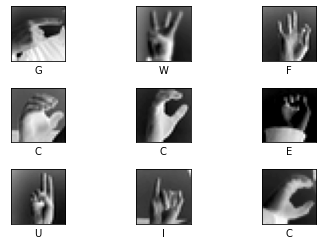

In [10]:
display_images(next_batch(9, x, y))

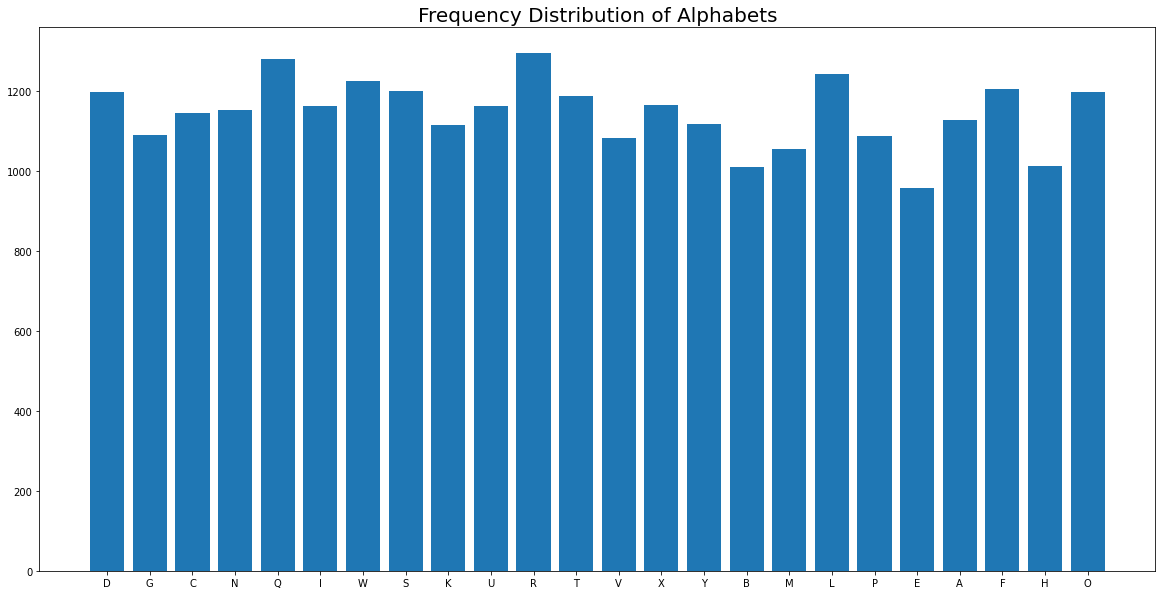

In [11]:
z = dict(Counter(list(y)))
labels = z.keys()
frequencies = [z[i] for i in labels]
labels = [chr(i + 65) for i in z.keys()]

plt.figure(figsize = (20, 10))
plt.bar(labels, frequencies)
plt.title('Frequency Distribution of Alphabets', fontsize = 20)
plt.show()

In [12]:
def one_hot_encode(y):
    return np.eye(25)[y]
y_encoded = one_hot_encode(y)
print('Shape of y after encoding:', y_encoded.shape)

Shape of y after encoding: (27455, 25)


## Building the Convolutional Neural Network

In [13]:
# Training Parameters
learning_rate = 0.001
epochs = 2000
batch_size = 128
display_step = 100

In [14]:
# Neural Network Hyperparameters
n_input = 784
n_classes = 25
dropout = 0.75

In [15]:
# Placeholders
X = tf.placeholder(tf.float32, shape = [None, n_input]) # Placeholder for Feature Matrix
Y = tf.placeholder(tf.float32, shape = [None, n_classes]) # Placeholder for Labels
keep_prob = tf.placeholder(tf.float32) # Placeholder for Dropout Rate

In [16]:
weights = {
    # Weight for Convolutional Layer 1: 5x5 filter, 1 input channel, 32 output channels
    'w1' : tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # Weight for Convolutional Layer 2: 5x5 filter, 32 input channels, 64 output channels
    'w2' : tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # Weight for Fully Connected Layer 1: 49 * 64 input channels, 1024 output channels
    'w3' : tf.Variable(tf.random_normal([7 * 7 * 64, 1024])),
    # Weight for Convolutional Layer 1: 1024 input channels, 25(number of classes) output channels
    'w4' : tf.Variable(tf.random_normal([1024, n_classes]))
}

In [17]:
biases = {
    # Bias for Convolutional Layer 1
    'b1' : tf.Variable(tf.random_normal([32])),
    # Bias for Convolutional Layer 2
    'b2' : tf.Variable(tf.random_normal([64])),
    # Bias for Fully Connected Layer 1
    'b3' : tf.Variable(tf.random_normal([1024])),
    # Bias for Outout Layer
    'b4' : tf.Variable(tf.random_normal([n_classes]))
}

In [18]:
# Wrapper function for creating a Convolutional Layer
def conv2d(x, W, b, strides = 1):
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [19]:
# Wrapper function for creating a Pooling Layer
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

In [20]:
def neural_network(x, weight, bias, dropout):
    x = tf.reshape(x, shape = [-1, 28, 28, 1])
    
    conv1 = conv2d(x, weight['w1'], bias['b1']) # Convolutional Layer 1
    conv1 = maxpool2d(conv1) # Pooling Layer 1
    
    conv2 = conv2d(conv1, weight['w2'], bias['b2']) # Convolutional Layer 1
    conv2 = maxpool2d(conv2) # Pooling Layer 1
    
    # Fully Connected Layer 1
    # Reshaping output of previous convolutional layer to fit the fully connected layer
    fc = tf.reshape(conv2, [-1, weights['w3'].get_shape().as_list()[0]])
    fc = tf.add(tf.matmul(fc, weight['w3']), bias['b3']) # Linear Function
    fc = tf.nn.relu(fc) # Activation Function
    
    fc = tf.nn.dropout(fc, dropout) # Applying dropout on Fully Connected Layer
    
    out = tf.add(tf.matmul(fc, weight['w4']), bias['b4']) # Output Layer
    return out

In [21]:
logits = neural_network(X, weights, biases, keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
loss_op = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = Y)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

In [23]:
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [24]:
init = tf.global_variables_initializer()

## Training the Neural Network

In [25]:
# Splitting the dataset into Training and Holdout(Test set)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size = 0.33, random_state = 42)
print('X train shape', X_train.shape)
print('y train shape', y_train.shape)
print('X test shape', X_test.shape)
print('y test shape', y_test.shape)

X train shape (18394, 784)
y train shape (18394, 25)
X test shape (9061, 784)
y test shape (9061, 25)


In [26]:
saver = tf.train.Saver()

In [27]:
with tf.Session() as sess:
    # Running Initializer
    sess.run(init)
    cost_hist, acc_hist = [], []
    for epoch in range(1, epochs + 1):
        _x, _y = next_batch(batch_size, X_train, y_train)
        # Running Optimizer
        sess.run(train_op, feed_dict = { X : _x, Y : _y, keep_prob : dropout })
        if epoch % display_step == 0:
            # Calculating Loss and Accuracy on the current Epoch
            loss, acc = sess.run([loss_op, accuracy], feed_dict = { X : _x, Y : _y, keep_prob : 1.0 })
            loss = sum(loss)
            cost_hist.append(loss)
            acc_hist.append(acc)
            print('Epoch ' + str(epoch) + ', Cost: ' + str(loss) + ', Accuracy: ' + str(acc * 100) + ' %')
    print('-' * 50)
    print('\nOptimization Finished\n')
    print('Accuracy on Training Data: ' + str(sess.run(accuracy,
                                                       feed_dict = {
                                                           X : X_train,
                                                           Y : y_train,
                                                           keep_prob : 1.0
                                                       }) * 100) + ' %')
    print('Accuracy on Test Data: ' + str(sess.run(accuracy,
                                                   feed_dict = {
                                                       X : X_test,
                                                       Y : y_test,
                                                       keep_prob : 1.0
                                                   }) * 100) + ' %')
    saver.save(sess, './basic_cnn_model.ckpt')

Epoch 100, Cost: 187068233.0, Accuracy: 36.71875 %
Epoch 200, Cost: 51340333.6875, Accuracy: 62.5 %
Epoch 300, Cost: 10692627.03125, Accuracy: 82.03125 %
Epoch 400, Cost: 7950962.25, Accuracy: 82.03125 %
Epoch 500, Cost: 6295083.609375, Accuracy: 84.375 %
Epoch 600, Cost: 2027978.21875, Accuracy: 89.0625 %
Epoch 700, Cost: 2140787.375, Accuracy: 92.1875 %
Epoch 800, Cost: 2025669.90625, Accuracy: 91.40625 %
Epoch 900, Cost: 1455492.15625, Accuracy: 91.40625 %
Epoch 1000, Cost: 294502.765625, Accuracy: 96.875 %
Epoch 1100, Cost: 106719.5625, Accuracy: 96.875 %
Epoch 1200, Cost: 171630.3125, Accuracy: 97.65625 %
Epoch 1300, Cost: 10810.15625, Accuracy: 99.21875 %
Epoch 1400, Cost: 283969.84375, Accuracy: 98.4375 %
Epoch 1500, Cost: 20774.03125, Accuracy: 99.21875 %
Epoch 1600, Cost: 55376.5, Accuracy: 98.4375 %
Epoch 1700, Cost: 260009.078125, Accuracy: 98.4375 %
Epoch 1800, Cost: 150924.0625, Accuracy: 99.21875 %
Epoch 1900, Cost: 94743.25, Accuracy: 98.4375 %
Epoch 2000, Cost: 197205.5

In [ ]:
sess.to_jso

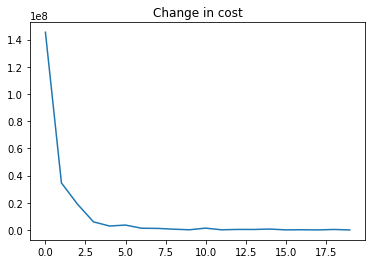

In [28]:
plt.plot(list(range(len(cost_hist))), cost_hist)
plt.title("Change in cost")
plt.show()

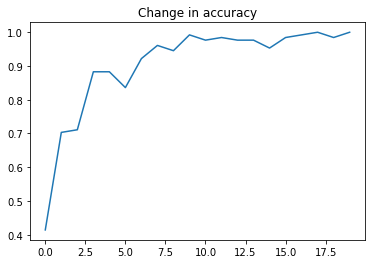

In [29]:
plt.plot(list(range(len(acc_hist))), acc_hist)
plt.title("Change in accuracy")
plt.show()